In [53]:
import orjson
import numpy as np

catalog_file = 'catalog/catalog.json'
with open(catalog_file, 'rb') as f:
    catalog = orjson.loads(f.read())
print("Number of events in catalog:", len(catalog['events']))
# (lon, lat)
injected_coord = [(np.rad2deg(e['injection']['ra']), np.rad2deg(e['injection']['dec'])) for e in catalog['events']]
recovered_coord = [(e['phi'][2], e['theta'][2]) for e in catalog['events']]

Number of events in catalog: 74


In [54]:
import plotly.graph_objects as go
import numpy as np
fig = go.Figure()

fig.update_layout(
    title="Vector on Earth",
    geo=dict(
        # projection_type="orthographic",  # Globe-like projection
        projection_type="natural earth",  # Natural Earth projection
        showland=True,
        showcountries=False,
        lataxis_showgrid=True,
        lonaxis_showgrid=True,
        center=dict(
            lat=0,  # Center the globe at the equator
            lon=0   # Center the globe at the prime meridian
        ),
    )
)

fig.add_trace(go.Scattergeo(
    lon=[coord[0] for coord in recovered_coord],
    lat=[coord[1] for coord in recovered_coord],
    mode='markers',
    name='Recovered',
    marker=dict(size=5),
))

fig.add_trace(go.Scattergeo(
    lon=[coord[0] for coord in injected_coord],
    lat=[coord[1] for coord in injected_coord],
    mode='markers',
    name='Injected',
    marker=dict(size=5, color='red'),
))

# connect between recovered and injected
for rec, inj in zip(recovered_coord, injected_coord):
    fig.add_trace(go.Scattergeo(
        lon=[rec[0], inj[0]],
        lat=[rec[1], inj[1]],
        mode='lines',
        name='Connection',
        line=dict(color='blue', width=1),
        showlegend=False
    ))

fig.show()

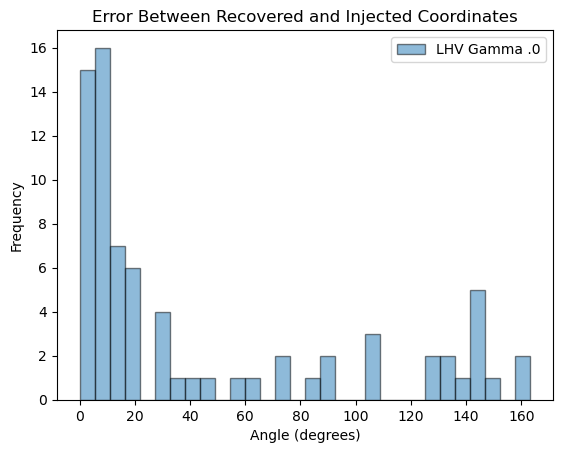

In [56]:
# compute the angle between recovered and injected
import numpy as np
def angle_between(coord1, coord2):
    """
    Calculate the angle between two coordinates on a sphere.
    Coordinates are in (longitude, latitude) format.
    """
    lon1, lat1 = np.deg2rad(coord1)
    lon2, lat2 = np.deg2rad(coord2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = (np.sin(dlat / 2) ** 2 +
         np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return np.rad2deg(c)

angles = [angle_between(rec, inj) for rec, inj in zip(recovered_coord, injected_coord)]
# bin the angles
import matplotlib.pyplot as plt
# Use the same bins for both histograms
bins = np.linspace(0, max(angles), 31)
plt.hist(angles, bins=bins, edgecolor='black', alpha=0.5, label='LHV Gamma .0')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.title('Error Between Recovered and Injected Coordinates')
plt.legend()
plt.show()